# Analysing output of t2p
This is a short script we will use as a demo on how to use the outputs of t2p for longitudinal analysis, but for now it is a practice notebook for Manon :)

The example here is for a 1 plane recording with simultaneous videography (given dataset is jm032). Track2p should be run on days (including) 19.10.2023 - 23.10.2023.

### Task description:

We want to know:
- Are there neurons in our recordings that are correlated with movement
- If yes, how stable is this correlation (are the same neurons correlated with movement on different days?, this can only be done with matched cells)
- Is this the case for all ages? If not when does this correlation arise?

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import os

### Step by step guide (more detailed explanations below):

Each point from this list matches one section of this notebook

1) Load the output of track2p
2) Find cells that are present in all recordings ('matched cells')
3) Load the data from one example dataset and visualise it
4) Load the activity of the matched cells
5) Visualise the activity of matched cells
6) Load the 'movement' data 
7) Study the correlation of movement and matched cells data

### 1) Load the output of track2p
The simplest way to do this is to load the `.npy` file: `t2p_output_path/track2p/plane#_match_mat.npy`. In this example it is simple because we only have one plane.

In [2]:
# first load the t2p ops
t2p_save_path = 'data_proc/jm/jm019/' # change this


In [3]:
# use np.load()
t2p_match_mat = np.load(os.path.join(t2p_save_path, 'track2p', 'plane0_match_mat.npy'), allow_pickle=True)

In [4]:
# what is the shape of this matrix?
# what do you think the rows and columns represent?
print(t2p_match_mat.shape)

(837, 4)


### 2) Find cells that are present in all recordings ('matched cells')



Now from this matrix get the matches that are present on all days (Hint: use the information below from the README)

- A matrix (`plane#_match_mat.npy`) containing the indices of matched neurons across the session for a given plane (`#` is the index of the plane). Since matching is done from first day to last, some neurons will not be sucessfully tracked after one or a few days. In this case the matrix contains `None` values. To get neurons tracked across all days only take the rows of the matrices containing no `None` values. 

In [5]:
# get the rows that do not contain any Nones
t2p_match_mat_allday = t2p_match_mat[~np.any(t2p_match_mat==None, axis=1), :]

In [6]:
# what is the shape of this new matrix? (this is the number of cells that were successfully matched across all days)
t2p_match_mat_allday.shape

(356, 4)

### 3) Load the data from one example dataset and visualise it


Hint: A nice way to implement this is to take the data saved in track_ops.npy file (for example to access the paths of the datasets used for t2p, see example below)

In [7]:
track_ops_dict = np.load(os.path.join(t2p_save_path, 'track2p', 'track_ops.npy'), allow_pickle=True).item()


In [8]:
# create dummy object from the track_ops dictionary
from types import SimpleNamespace
track_ops = SimpleNamespace(**track_ops_dict)

In [9]:
print('Datasets used for t2p:\n')
for ds_path in track_ops.all_ds_path:
    print(ds_path)

Datasets used for t2p:

data_proc/jm/jm019/2023-04-05_a
data_proc/jm/jm019/2023-04-06_a
data_proc/jm/jm019/2023-04-07_a
data_proc/jm/jm019/2023-04-08_a


For this part it is important to know a bit about how the suite2p structures the outputs: https://suite2p.readthedocs.io/en/latest/outputs.html (the important things will be the `ops.npy`, `stat.npy`, `iscell.npy` and the `F.npy`)
As an exercise you can first do it for a single dataset.

In [10]:
# lets take the last dataset
last_ds_path = track_ops.all_ds_path[-1]
print(f'We will look at the dataset saved at: {last_ds_path}')

We will look at the dataset saved at: data_proc/jm/jm019/2023-04-08_a


In [11]:
# load the three files
last_ops = np.load(os.path.join(last_ds_path, 'suite2p', 'plane0', 'ops.npy'), allow_pickle=True).item()
last_stat = np.load(os.path.join(last_ds_path, 'suite2p', 'plane0', 'stat.npy'), allow_pickle=True)
last_f = np.load(os.path.join(last_ds_path, 'suite2p', 'plane0', 'F.npy'), allow_pickle=True)
iscell = np.load(os.path.join(last_ds_path, 'suite2p', 'plane0', 'iscell.npy'), allow_pickle=True)

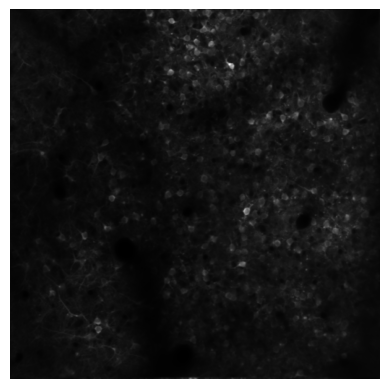

In [12]:
# now first plot the mean image of the movie (it is saved in ops.npy, for more infor see the suite2p outputs documentation)
plt.imshow(last_ops['meanImg'], cmap='gray')
plt.axis('off')
plt.show()

(-0.5, 511.5, 511.5, -0.5)

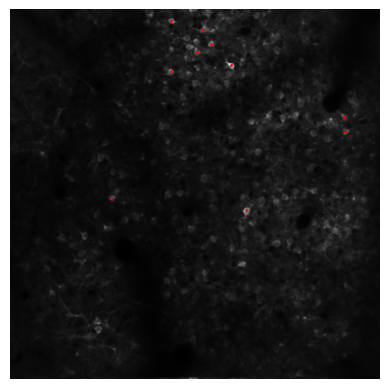

In [13]:
# next scatter the location of the first n cells onto the average image (use the stat.npy file, and plot the median coordinates for each cell) start with first 10 cells, then try more (you can also try to show all)
# Hint: Be careful about getting the x and y coordinates correct (images use a different convention than sccatter), you can verify you did it correctly if the scatter points are on top of the cells
n = 10

plt.imshow(last_ops['meanImg'], cmap='gray')
for i in range(n):
    plt.scatter(last_stat[i]['med'][1], last_stat[i]['med'][0], s=1, color='r')
plt.axis('off')

In [14]:
# if you plot all entries from stat you can see that there are a lot of things detected (too many to be cells), so we need to filter them out
# luckily suite2p tells us how confident it is that something is a cell in the iscell.npy file (see the suite2p outputs documentation for more info)

# lets use the same confidence that we used when we ran track2p
iscell_thr = track_ops.iscell_thr
print(f'The iscell threshold used was: {iscell_thr}')

The iscell threshold used was: 0.5


In [15]:
# now use the iscell.npy file to filter out the cells that are not confident enough (use the second column of the iscell.npy file)
stat_iscell = last_stat[iscell[:,1]>iscell_thr]

In [16]:
print(f'Got {stat_iscell.shape[0]} (/{last_stat.shape[0]}) cells using the iscell threshold')

Got 855 (/1849) cells using the iscell threshold


(-0.5, 511.5, 511.5, -0.5)

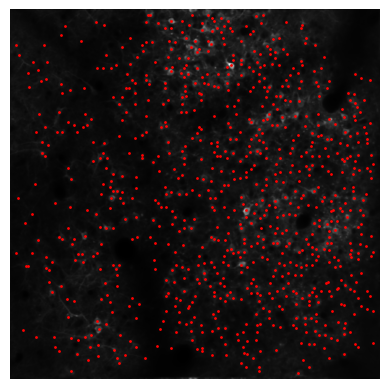

In [17]:
# now plot the median coordinates of the cells that are confident enough
plt.imshow(last_ops['meanImg'], cmap='gray')
for i in range(len(stat_iscell)):
    plt.scatter(stat_iscell[i]['med'][1], stat_iscell[i]['med'][0], s=1, color='r')
plt.axis('off')

In [18]:
# good! now we can move on to looking at the activity of the cells. First plot the activity of the first cell as a time-series (use the F.npy file, the cells here are matched to the cells in stat.npy)
print(f'len of stat: {len(last_stat)}')
print(f'shape of F: {last_f.shape}')


len of stat: 1849
shape of F: (1849, 36000)


Text(0, 0.5, 'F')

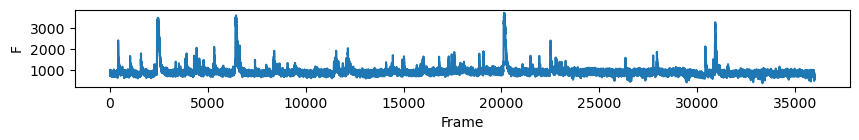

In [19]:
# you can see that the rows of F are the cells and the columns are the frames of the movie
# lets plot the first cell (hint: use a wide figure)
plt.figure(figsize=(10, 1))
i = 0

plt.plot(last_f[i, :])
plt.xlabel('Frame')
plt.ylabel('F')

Now lets plot the activity of all cells as a 'raster plot'.
A raster plot is just a heatmap of the F matrix. By convention we use black as the cell being activated (high value) and white as the cell not being activated (low value).
For visualisation purposes we also normalize each row by z-scoring (you can try with or without to see the difference). 

Hint: Set the vmin to 0 and vmax to 1.96 in the imshow to see the activity better.

For example of how a raster should look, see figure G or H [here](https://www.science.org/cms/10.1126/science.aav7893/asset/1f184dca-7c86-432c-8d81-b4529619480d/assets/graphic/364_aav7893_f1.jpeg).

In [20]:
from scipy.stats import zscore

In [21]:
# also filter by the iscell threshold
last_f_iscell = last_f[iscell[:,1]>iscell_thr, :]

In [22]:
last_f_iscell_zscore = zscore(last_f_iscell, axis=1)

In [23]:
# check that row 0 is now zscored (mean should be 0 and std should be 1)
row_std = np.std(last_f_iscell_zscore[0, :])
row_mean = np.mean(last_f_iscell_zscore[0, :])
print(f'row 0 std: {row_std}')
print(f'row 0 mean: {row_mean}')

row 0 std: 1.0
row 0 mean: -2.3057725684338948e-07


Text(0, 0.5, 'Cell')

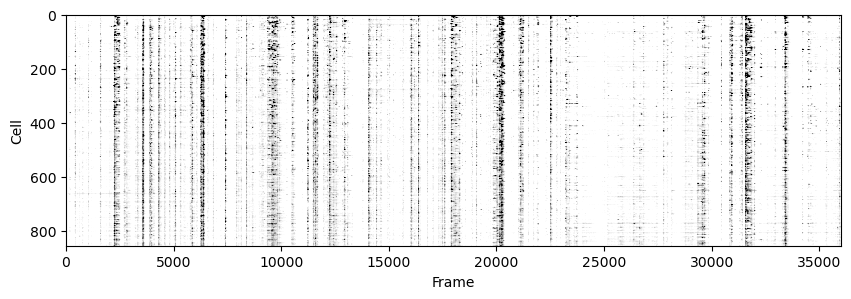

In [24]:
plt.figure(figsize=(10, 3))
plt.imshow(last_f_iscell_zscore, aspect='auto', cmap='Greys', vmin=0, vmax=1.96)
plt.xlabel('Frame')
plt.ylabel('Cell')

Extra task: People often plot the mean activity of all cells for each timepoint as a subplot below a raster. Implement this as an extra task.

In [25]:
## TODO:

## 4) Load the activity of the matched cells

Now that we know how to look at data in one recording we will use the output from track2p to look at activity of the same cells across all datasets.

To do this we need to loop through all datasets and:
- load the files described above
- filter `stat.npy` and `fluo.npy` by the track2p iscell threshold
- filter `stat.npy` and `fluo.npy` by the appropriate indices from the matrix of neurons matched on all days

In [26]:
iscell_thr = track_ops.iscell_thr # use the same threshold as when running the algo (to be consistent with indexing)

all_stat_t2p = []
all_f_t2p = []
all_ops = [] # ops dont change

for (i, ds_path) in enumerate(track_ops.all_ds_path):
    ops = np.load(os.path.join(ds_path, 'suite2p', 'plane0', 'ops.npy'), allow_pickle=True).item()
    stat = np.load(os.path.join(ds_path, 'suite2p', 'plane0', 'stat.npy'), allow_pickle=True)
    f = np.load(os.path.join(ds_path, 'suite2p', 'plane0', 'F.npy'), allow_pickle=True)
    iscell = np.load(os.path.join(ds_path, 'suite2p', 'plane0', 'iscell.npy'), allow_pickle=True)
    
    stat_iscell = stat[iscell[:,1]>iscell_thr]
    f_iscell = f[iscell[:,1]>iscell_thr, :]
    
    stat_t2p = stat_iscell[t2p_match_mat_allday[:,i].astype(int)]
    f_t2p = f_iscell[t2p_match_mat_allday[:,i].astype(int), :]

    all_stat_t2p.append(stat_t2p)
    all_f_t2p.append(f_t2p)
    all_ops.append(ops)



to make sure it worked plot a little window around the median coordinates of cell c (once implemented try for different c)


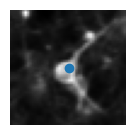

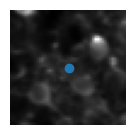

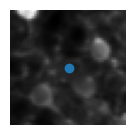

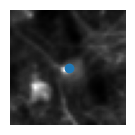

In [27]:
wind = 24
c = 0

for i in range(len(track_ops.all_ds_path)):
    mean_img = all_ops[i]['meanImg']
    stat_t2p = all_stat_t2p[i]
    median_coord = stat_t2p[c]['med']

    plt.figure(figsize=(1.5,1.5))
    plt.imshow(mean_img[int(median_coord[0])-wind:int(median_coord[0])+wind, int(median_coord[1])-wind:int(median_coord[1])+wind], cmap='gray')
    plt.scatter(wind, wind)
    plt.axis('off')
    plt.show()

### 5) Visualise the activity of matched cells

Once you are sure that it works you can repeat a similar exercise as for a single dataset, but for matched cells.

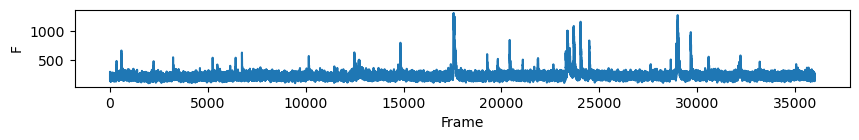

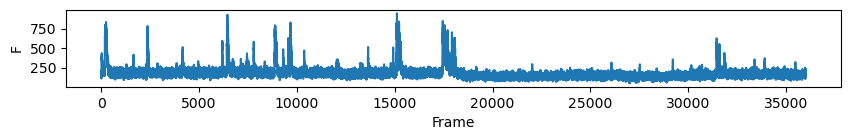

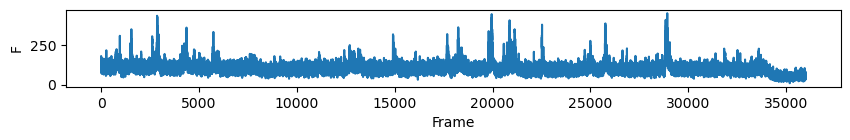

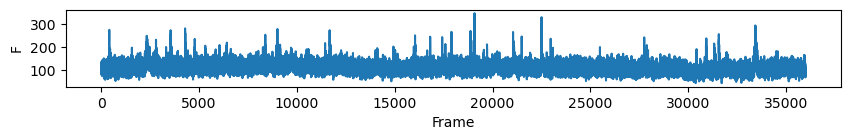

In [28]:
# first plot the trace of cell c for all days
c = 10

for i in range(len(track_ops.all_ds_path)):
    plt.figure(figsize=(10, 1)) # make a wide figure
    plt.plot(all_f_t2p[i][c, :])
    plt.xlabel('Frame')
    plt.ylabel('F')
    plt.show()


Now plot the rasters of all matched cells for all days (note1: using the sorting of the f matrix from the t2p algo will mean the first row is the same cell across days and so on; note2: don't forget to zscore the rows)

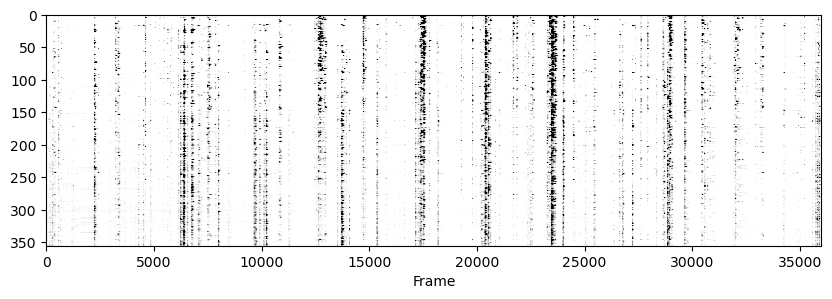

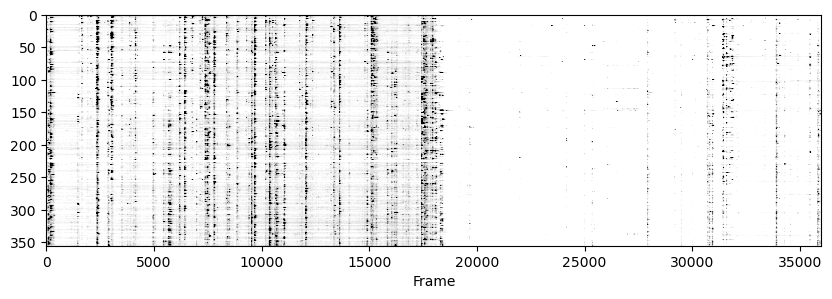

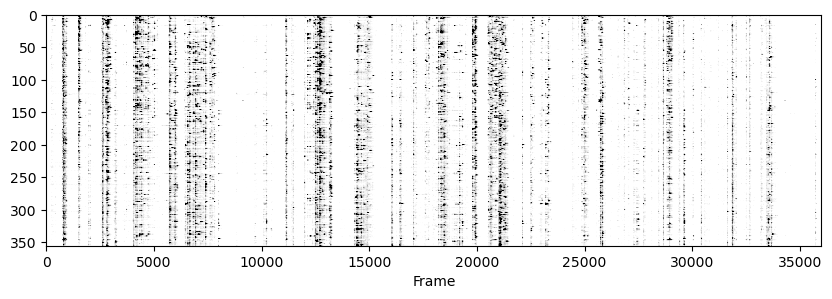

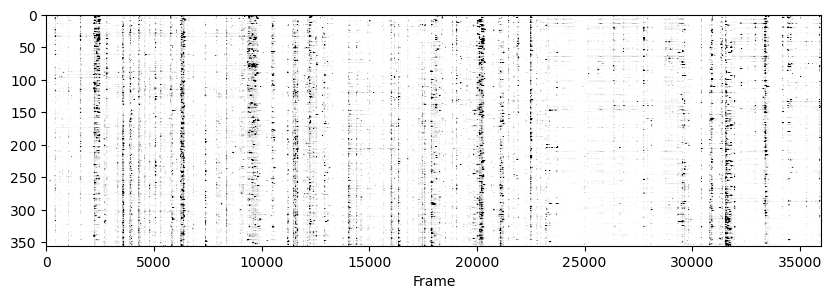

In [29]:
for i in range(len(track_ops.all_ds_path)):
    plt.figure(figsize=(10, 3)) # make a wide figure
    f_plot = zscore(all_f_t2p[i], axis=1)
    plt.imshow(f_plot, aspect='auto', cmap='Greys', vmin=0, vmax=2.56)
    plt.xlabel('Frame') 

In [30]:
# it might not be so visible, but some of the cells have all zeros in activity (which is a suite2p bug). We need to remove all cells that have this on any day
zero_cells = np.zeros(all_f_t2p[0].shape[0])
for i in range(len(track_ops.all_ds_path)):
    zero_cells = zero_cells + np.all(all_f_t2p[i]==0, axis=1)

zero_cells = zero_cells.astype(bool)
print(f'Found {np.sum(zero_cells)} cells that have all zero activity')

# now remove these cells from all_f_t2p and all_stat_t2p
all_f_t2p = [f[~zero_cells, :] for f in all_f_t2p]
all_stat_t2p = [stat[~zero_cells] for stat in all_stat_t2p]


Found 1 cells that have all zero activity


### 6) Load the 'movement' data 
'Movement' data is something I calculated beforehand from video, but basically its just vector of the same lenght as the number of frames and it quantifies how much the mouse is moving globally at that time point.

The data is stored at the root of each dataset folder under `cam_analysis/motion_energy.npy`

In [31]:
all_mot_energy = []

for i in range(len(track_ops.all_ds_path)):
    mot_energy = np.load(os.path.join(track_ops.all_ds_path[i], 'cam_analysis', 'motion_energy.npy'), allow_pickle=True)
    all_mot_energy.append(mot_energy)

FileNotFoundError: [Errno 2] No such file or directory: 'data_proc/jm/jm019/2023-04-05_a/cam_analysis/motion_energy.npy'

In [ ]:
# now plot the motion energy for all days, do you notice anything interesting?
for i in range(len(track_ops.all_ds_path)):
    plt.figure(figsize=(10, 1)) # make a wide figure
    plt.plot(all_mot_energy[i])
    plt.xlabel('Frame')
    plt.ylabel('Motion Energy')
    plt.show()

### 7) Study the correlation of movement and matched cells data
This is the interesting part.

Lets first compute for each dataset separately how correlated each cell is to movement (only use matched cells) 

(due to some technical issues the number of camera frames is a bit shorter than the number of microscope frames, so we can just shorten the f matrix for a few frames (see already implemented code))

In [ ]:
all_f_mot_corr = []

for i in range(len(track_ops.all_ds_path)):
    mot_energy = all_mot_energy[i]
    print(f'mot_energy is {mot_energy.shape[0]}, shortening f by {all_f_t2p[i].shape[1] - mot_energy.shape[0]} frames')
    f = all_f_t2p[i][:, :mot_energy.shape[0]]
    f_mot_corr = np.zeros(f.shape[0])
    for j in range(f.shape[0]):
        f_mot_corr[j] = np.corrcoef(f[j,:], mot_energy)[1,0] # take the off-diagonal (cross-correlation)
    all_f_mot_corr.append(f_mot_corr)

In [ ]:
# plot the distributions as histogram (make sure to use the same bins for all days so you can compare)
# what do you notice?
bins = np.linspace(-1, 1, 50) # correlation coefficient is between -1 and 1

for i in range(len(track_ops.all_ds_path)):
    plt.figure(figsize=(3,3)) # make a wide figure
    plt.hist(all_f_mot_corr[i], bins=bins)
    plt.xlabel('Correlation Coefficient')
    plt.ylabel('Count')
    plt.show()

In [ ]:
# plot the trace of the cell with the highest correlation coefficient for each day overlayed by the motion energy (normalize both with zscore)
# what do you notice?
for i in range(len(track_ops.all_ds_path)):
    plt.figure(figsize=(10, 1)) # make a wide figure
    f_plot = zscore(all_f_t2p[i], axis=1)
    plt.plot(f_plot[np.argmax(all_f_mot_corr[i]), :])
    plt.plot(zscore(all_mot_energy[i]))
    plt.xlabel('Frame')
    plt.ylabel('F')
    plt.show()

In this last part we will check if the same cells are correlated with movement across days? (we can only do this because we matched the cells)

In [ ]:
# first approach: are the top n most correlated neurons the same for all days?
# what do you notice? Espeically comparing early vs late days?
n = 20

for i in range(len(track_ops.all_ds_path)):
    print(f'For day {i} the most correlated cells are:')
    print(np.sort(np.argsort(all_f_mot_corr[i])[-n:]))

In [ ]:
# last task: Can we do this a bit more systematically?
# lets look at how correlations of subsets of neruons change across days 

# take:
#  - n most correlated cells on first day
#  - n most correlated cells on last day
#  - n random cells (control)

# and plot their correlation with behaviour across days
# what do you notice? Are the correlations stable across days?

n = 20

# first day
first_inds = np.argsort(all_f_mot_corr[0])[-n:]
last_inds = np.argsort(all_f_mot_corr[-1])[-n:]
rand_inds = np.random.choice(len(all_f_mot_corr[0]), n, replace=False)

# make all days correlations into a matrix (to be able to index more easily later)
all_f_mot_corr_mat = np.array(all_f_mot_corr)

# now get the correlations of these cells across all days
first_corrs = all_f_mot_corr_mat[:, first_inds]
last_corrs = all_f_mot_corr_mat[:, last_inds]
rand_corrs = all_f_mot_corr_mat[:, rand_inds]


for (i, corrs) in enumerate([first_corrs, last_corrs, rand_corrs]):
    plt.figure(figsize=(3, 3)) # make a wide figure
    plt.plot(corrs, color=f'C{i}', alpha=0.5)
    plt.xlabel('Day') 
    plt.ylabel('Cell')
    plt.ylim([-0.3, 0.6])


    